# Анализ рынка строительной отрасли

Для начала подключим нужные библиотеки python

In [11]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

## Читаем ИНН компаний

С сайта https://ofd.nalog.ru/ скачиваем xlxs файл с данными о всех компаниях в строительной отрасли (Виды деятельности - 41.2) в файл с названием rsmp_05.02.2025.xlsx

Считаем ИНН всех компаний, которые нашлись на этом сайте, и переведём данные ИНН в массив

In [12]:
data_inn = pd.read_excel("data/rsmp_05.02.2025.xlsx", skiprows=2, engine="openpyxl")
array_inn = np.array(data_inn['ИНН'].to_list())

## Читаем id компаний

Будем скачивать id компаний с сайта https://bo.nalog.ru/ с помощью requests.Session(), а также используя следующий запрос к сайту:

>https://bo.nalog.ru/advanced-search/organizations/search?query={<здесь указывается ИНН>}&page=0

Id нам понадобятся, когда мы начнём собирать финансовую отчётность компаний

**Следующая ячейка для скачивания данных. Не запускайте её, если данные уже есть в папке data**

In [1]:
session = requests.Session()
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

with open('data/companies_id_inn.csv', 'w', encoding='utf-8') as output:
    output.writelines(["inn,id\n"])
    try:
        for i in tqdm(range(len(array_inn))):
            url = f'https://bo.nalog.ru/advanced-search/organizations/search?query={array_inn[i]}&page=0'
            res = session.get(url,headers=headers).json()
            if not res["content"]:
                continue
            org_id = res["content"][0]["id"]
            output.writelines([f"{array_inn[i]},{str(org_id)}\n"])
    except Exception as e:
        print("Ошибка:", e)

Прочитаем полученный csv файл и запишем id в массив

In [ ]:
data_inn_id = pd.read_csv("data/companies_id_inn.csv")
array_id = np.array(data_inn_id['id'].to_list())

## Читаем финансовые данные компаний

Оказалось, что есть дополнительный способ поиска финансовой информации, он использует такой запрос
> https://bo.nalog.ru/nbo/organizations/{id}/bfo/

Именно для него нам и нужны были id компаний на сайте bo.nalog.ru

Эти колонки для таблицы мы будем считывать из json файла, который будем получать для каждой компании по нашему запросу

In [ ]:
necessary_columns = ['id', 'inn', 'fullName', 'address', 'period', 'revenue2110', 
                     'cost_sales2120', 'interest_payable2330', 'net_profit2400', 'income_tax2410']

Парсер для считываемых данных

In [ ]:
class DataJsonParser():
    def __init__(self, id = None, config = None):
        self.id = id
        self.inn = None
        self.fullName = None
        self.address = None
        self.period = None
        self.revenue2110 = None
        self.cost_sales2120 = None
        self.interest_payable2330 = None
        self.net_profit2400 = None
        self.income_tax2410 = None
        if config is not None:
            # self.id = config['id'] if 'id' in config.keys() else None
            self.period = config['period'] if 'period' in config.keys() else None
            if 'organizationInfo' in config.keys():
                tmp1 = config['organizationInfo']
                if tmp1 is not None:
                    self.inn = tmp1['inn'] if 'inn' in tmp1.keys() else None
                    self.fullName = f'"{str(tmp1["fullName"]).replace("\"", "\"\"")}"' if "fullName" in tmp1.keys() else None
                    self.address = f'"{str(tmp1["address"]).replace("\"", "\"\"")}"' if "address" in tmp1.keys() else None
            if 'correction' in config.keys() and (config['correction'] is not None) and ('financialResult' in config['correction'].keys()):
                tmp2 = config['correction']['financialResult']
                if tmp2 is not None:
                    self.revenue2110 = tmp2['current2110'] if 'current2110' in tmp2.keys() else None
                    self.cost_sales2120 = tmp2['current2120'] if 'current2120' in tmp2.keys() else None
                    self.interest_payable2330 = tmp2['current2330'] if 'current2330' in tmp2.keys() else None
                    self.net_profit2400 = tmp2['current2400'] if 'current2400' in tmp2.keys() else None
                    self.income_tax2410 = tmp2['current2410'] if 'current2410' in tmp2.keys() else None
        self.row = self.makeCSVRow()
    
    def makeCSVRow(self):
        return f"{self.id},{self.inn},{self.fullName},{self.address},{self.period},{self.revenue2110},"\
               f"{self.cost_sales2120},{self.interest_payable2330},{self.net_profit2400},{self.income_tax2410}\n"

Читаем данные

**Следующая ячейка для скачивания данных. Не запускайте её, если данные уже есть в папке data**

In [ ]:
session = requests.Session()
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

with open("data/companies_data.csv", "w", encoding='utf-8') as output:
    output.writelines([','.join(necessary_columns)+'\n'])
    try:
        for i in tqdm(range(len(array_id))):
            url = f'https://bo.nalog.ru/nbo/organizations/{array_id[i]}/bfo/'
            res = session.get(url,headers=headers).json()
            for elem in res:
                data_json = DataJsonParser(array_id[i], elem)
                output.writelines([data_json.row])
    except Exception as e:
        print("Ошибка:", e)

## Анализ отрасли

### Первый взгляд на данные

Скачаем финансовые данные строительных организаций и посмотрим на них

In [16]:
companies_data = pd.read_csv("data/companies_data.csv")
companies_data['id'] = companies_data['id'].astype(int)
companies_data.head(4)

,id,inn,fullName,address,period,revenue2110,cost_sales2120,interest_payable2330,net_profit2400,income_tax2410
0,5872486,5.038039e+09,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОРП...","141206, Московская обл, ул Чехова, 12, офис 901",2023,108966.0,90500.0,3334.0,-20913.0,-248.0
1,5872486,5.038039e+09,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОРП...","141206, Московская обл, ул Чехова, 12, офис 901",2022,118633.0,83747.0,141.0,19518.0,-336.0
2,5872486,5.038039e+09,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОРП...","141206, Московская обл, ул Чехова, 12, офис 901",2021,184044.0,150023.0,5601.0,3080.0,-320.0
3,5872486,5.038039e+09,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КОРП...","141206, Московская обл, ул Чехова, 12, офис 901",2020,303726.0,293308.0,23013.0,-8543.0,-310.0


In [17]:
companies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41878 entries, 0 to 41877
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    41878 non-null  int64  
 1   inn                   41877 non-null  float64
 2   fullName              41877 non-null  object 
 3   address               41877 non-null  object 
 4   period                41878 non-null  int64  
 5   revenue2110           41193 non-null  float64
 6   cost_sales2120        40817 non-null  float64
 7   interest_payable2330  16229 non-null  float64
 8   net_profit2400        41432 non-null  float64
 9   income_tax2410        38733 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 3.2+ MB


По итогу, в таблице занесены финансовые результаты строительных компаний за 2020-2024 годы

In [18]:
companies_data.period.value_counts()

period
2023    10914
2022    10566
2021    10241
2020    10008
2024      149
Name: count, dtype: int64

Видно, что за 2024 ещё практически нет финансовой отчётности от компаний. Это связано с тем, что годовая бухгалтерская (финансовая) отчетность представляется в налоговую инспекцию или орган государственной статистики не позднее трех месяцев после окончания отчетного периода (https://its.1c.ru/docs/repdate/)

### Введение метрик

Посчитаем метрику EBITDA для фирм за 2020-2024 годы. Вкратце, эта метрика отражает прибыль компании, которая у неё получается до вычета налогов, уплаты процентов, оплаты амортизационных издержек. Этот показатель очищен от влияния разных систем налогообложения и учета. Он позволяет быстро сравнивать компании из разных стран с разной налоговой нагрузкой. 

Аналитики смотрят на этот показатель для анализа кредитоспособности предприятия. Собственники или крупные инвесторы могут учитывать его, когда запускают новые продукты или обдумывают слияние и поглощение.

Обычно EBITDA считается по формуле: 
$$ EBITDA = Чистая \; прибыль + Амортизация + Налоги + Проценты \; по \; кредитам$$
Но в нашей ситуации на сайте bo.nalog.ru компании нигде не указывают свои расходы на амортизацию, поэтому мы считали метрику по следующей формуле:
$$ EBITDA = Выручка - Общая \; себестоимость + Амортизация + Налоги + Проценты \; по \; кредитам$$

In [19]:
companies_data['EBITDA'] = companies_data['revenue2110'] - companies_data['cost_sales2120'] + companies_data['interest_payable2330'] + companies_data['income_tax2410']

Для скольких компаний по годам получилось посчитать эту метрику:

In [20]:
companies_data.loc[companies_data['EBITDA'].dropna().index].groupby('period')['EBITDA'].count()

period
2020    3458
2021    3748
2022    4024
2023    4213
2024      36
Name: EBITDA, dtype: int64

Теперь можно посчитать статистику по рентабельности строительных фирм за 2020-2024 годы, причём рентабельность в чистой прибыли и рентабельность через метрику EBITDA по формулам:
$$ Рентабельность \; (или \;  profit) = \frac{чистая \; прибыль}{выручка} * 100\%, \quad 
EBITDA \; рентабельность \; (или \; EBITDA \; Margin)  = \frac{EBITDA \; прибыль}{выручка} * 100\%$$

In [21]:
import math
EPS = 1.0e-06

companies_data = companies_data.assign(
                    profit_EBITDA=np.where(
                        abs(companies_data.revenue2110) < EPS,
                        None,
                        (companies_data.EBITDA/companies_data.revenue2110)*100
                    )                
                 )
companies_data = companies_data.assign(
                    profit=np.where(
                        abs(companies_data.revenue2110) < EPS,
                        None,
                        (companies_data.net_profit2400/companies_data.revenue2110)*100
                    )                
                 )

In [22]:
companies_data['profit']

0       -19.192225
1         16.45242
2         1.673513
3        -2.812733
4         0.076392
           ...    
41873      2.98082
41874     0.668355
41875     1.671854
41876     0.366945
41877     2.395122
Name: profit, Length: 41878, dtype: object

In [23]:
companies_data['profit_EBITDA']

0        19.778647
1        29.242285
2        21.354676
3        10.904895
4              NaN
           ...    
41873          NaN
41874     5.267119
41875     2.473406
41876     2.222689
41877     4.196965
Name: profit_EBITDA, Length: 41878, dtype: object

### Пропуски и ошибки в данных

Посмотрим на максимальную и минимальную рентабельность для фирм

In [24]:
profit_data = [companies_data[companies_data.period == i]['profit'].dropna() for i in range(2020, 2025)]
profit_data_ind = [elem.index for elem in profit_data]

profit_ebitda_data = [companies_data[companies_data.period == i]['profit_EBITDA'].dropna() for i in range(2020, 2025)]
profit_ebitda_data_ind = [elem.index for elem in profit_ebitda_data]

In [25]:
print( 'Максимальная рентабельность за 2020-2024 годы - ' + ' - '.join([str(round(elem .max())) +'%' for elem in profit_data]))
print( 'Минимальная рентабельность за 2020-2024 годы - ' + ' - '.join([str(round(elem .min())) +'%' for elem in profit_data]))

Максимальная рентабельность за 2020-2024 годы - 52961% - 28011% - 311003% - 100473% - 85%
Минимальная рентабельность за 2020-2024 годы - -170123% - -86756% - -429488% - -768400% - -12936%


In [26]:
print( 'Процент компаний с рентабельностью большей 100 % за 2020-2024 годы | ' + ' | '.join([str(round((np.where(elem >= 100, 1, 0).sum() / elem.shape[0])*100, 2))+'%' for elem in profit_data]))               
print( 'Процент компаний с рентабельностью меньшей -100 % за 2020-2024 годы | ' + ' | '.join([str(round((np.where(elem <= -100, 1, 0).sum() / elem.shape[0])*100, 2))+'%' for elem in profit_data]))               
print( 'Процент компаний с рентабельностью по модулю большей 100 % за 2020-2024 годы | ' + ' | '.join([str(round((np.where(abs(elem) >= 100, 1, 0).sum() / elem.shape[0])*100, 2))+'%' for elem in profit_data]))               

Процент компаний с рентабельностью большей 100 % за 2020-2024 годы | 0.51% | 0.65% | 0.79% | 0.93% | 0.0%
Процент компаний с рентабельностью меньшей -100 % за 2020-2024 годы | 1.26% | 1.06% | 1.81% | 2.87% | 10.28%
Процент компаний с рентабельностью по модулю большей 100 % за 2020-2024 годы | 1.77% | 1.71% | 2.61% | 3.8% | 10.28%


- Видим, что в данных есть выбросы по рентабельности. 

Хотя в 2024 году это нельзя назвать выбросами. Это прежде всего из-за того, что за 2024 мало финансовой отчётности, как было сказано ранее. А та, что подана аж в 10% случаев, относится к компаниям, у которых выручка очень маленькая, либо её вообще нет:

In [27]:
profit_data_bad = profit_data[4][profit_data[4] <= -100] 
profit_data_bad_ind = profit_data_bad.index
profit_data_bad_rev_sum = companies_data.loc[profit_data_bad_ind]['revenue2110'].median()
profit_data_bad_profit_sum = companies_data.loc[profit_data_bad_ind]['net_profit2400'].median()
print( 'Сумма выручки компаний с рентабельностью меньшей -100% за 2024 год | ' + str(profit_data_bad_rev_sum))              
print( 'Сумма прибыли компаний с рентабельностью меньшей -100% за 2024 год | ' + str(profit_data_bad_profit_sum))          

Сумма выручки компаний с рентабельностью меньшей -100% за 2024 год | 367.0
Сумма прибыли компаний с рентабельностью меньшей -100% за 2024 год | -2944.0


- Поэтому в дальнейшем, чтобы не исказить статистические выводы, не будем рассматривать 2024 год

In [28]:
profit_data = profit_data[:-1]
profit_data_ind = profit_data_ind[:-1]
profit_ebitda_data = profit_ebitda_data[:-1]
profit_ebitda_data_ind = profit_ebitda_data_ind[:-1]

Ещё заметим, что проблема с выбросами в данных не в подсчётах и не в самих данных. Например, сильно отрицательная рентабельность может быть у компании на рынке строительства за 1 год, из-за простоя. Вот, например, компания (https://bo.nalog.ru/organizations-card/10518351), которая в 2022 вообще ничем не занималась, в 2021 и после 2022 имела внушительные обороты.

### Анализ рынка по рентабельность и EBITDA

Насчёт рентабельности: чистая рентабельность может иметь следующие значения и следующие характеристики этих значений:
> 1–5% — низкая рентабельность, над увеличением которой надо работать
>
> 5–20% — средний показатель, при котором предприятие может стабильно работать
>
> 20–30% — высокая результативность работы.

Рентабельность же по EBITDA, если она выше 20%, считается хорошей: значит, бизнес работает эффективно и приносит доход.

Построим boxplot за разные годы, чтобы показать в каком диапазоне находятся рентабельность и рентабельность по EBITDA (EBITDA Margin) для строительных компаний

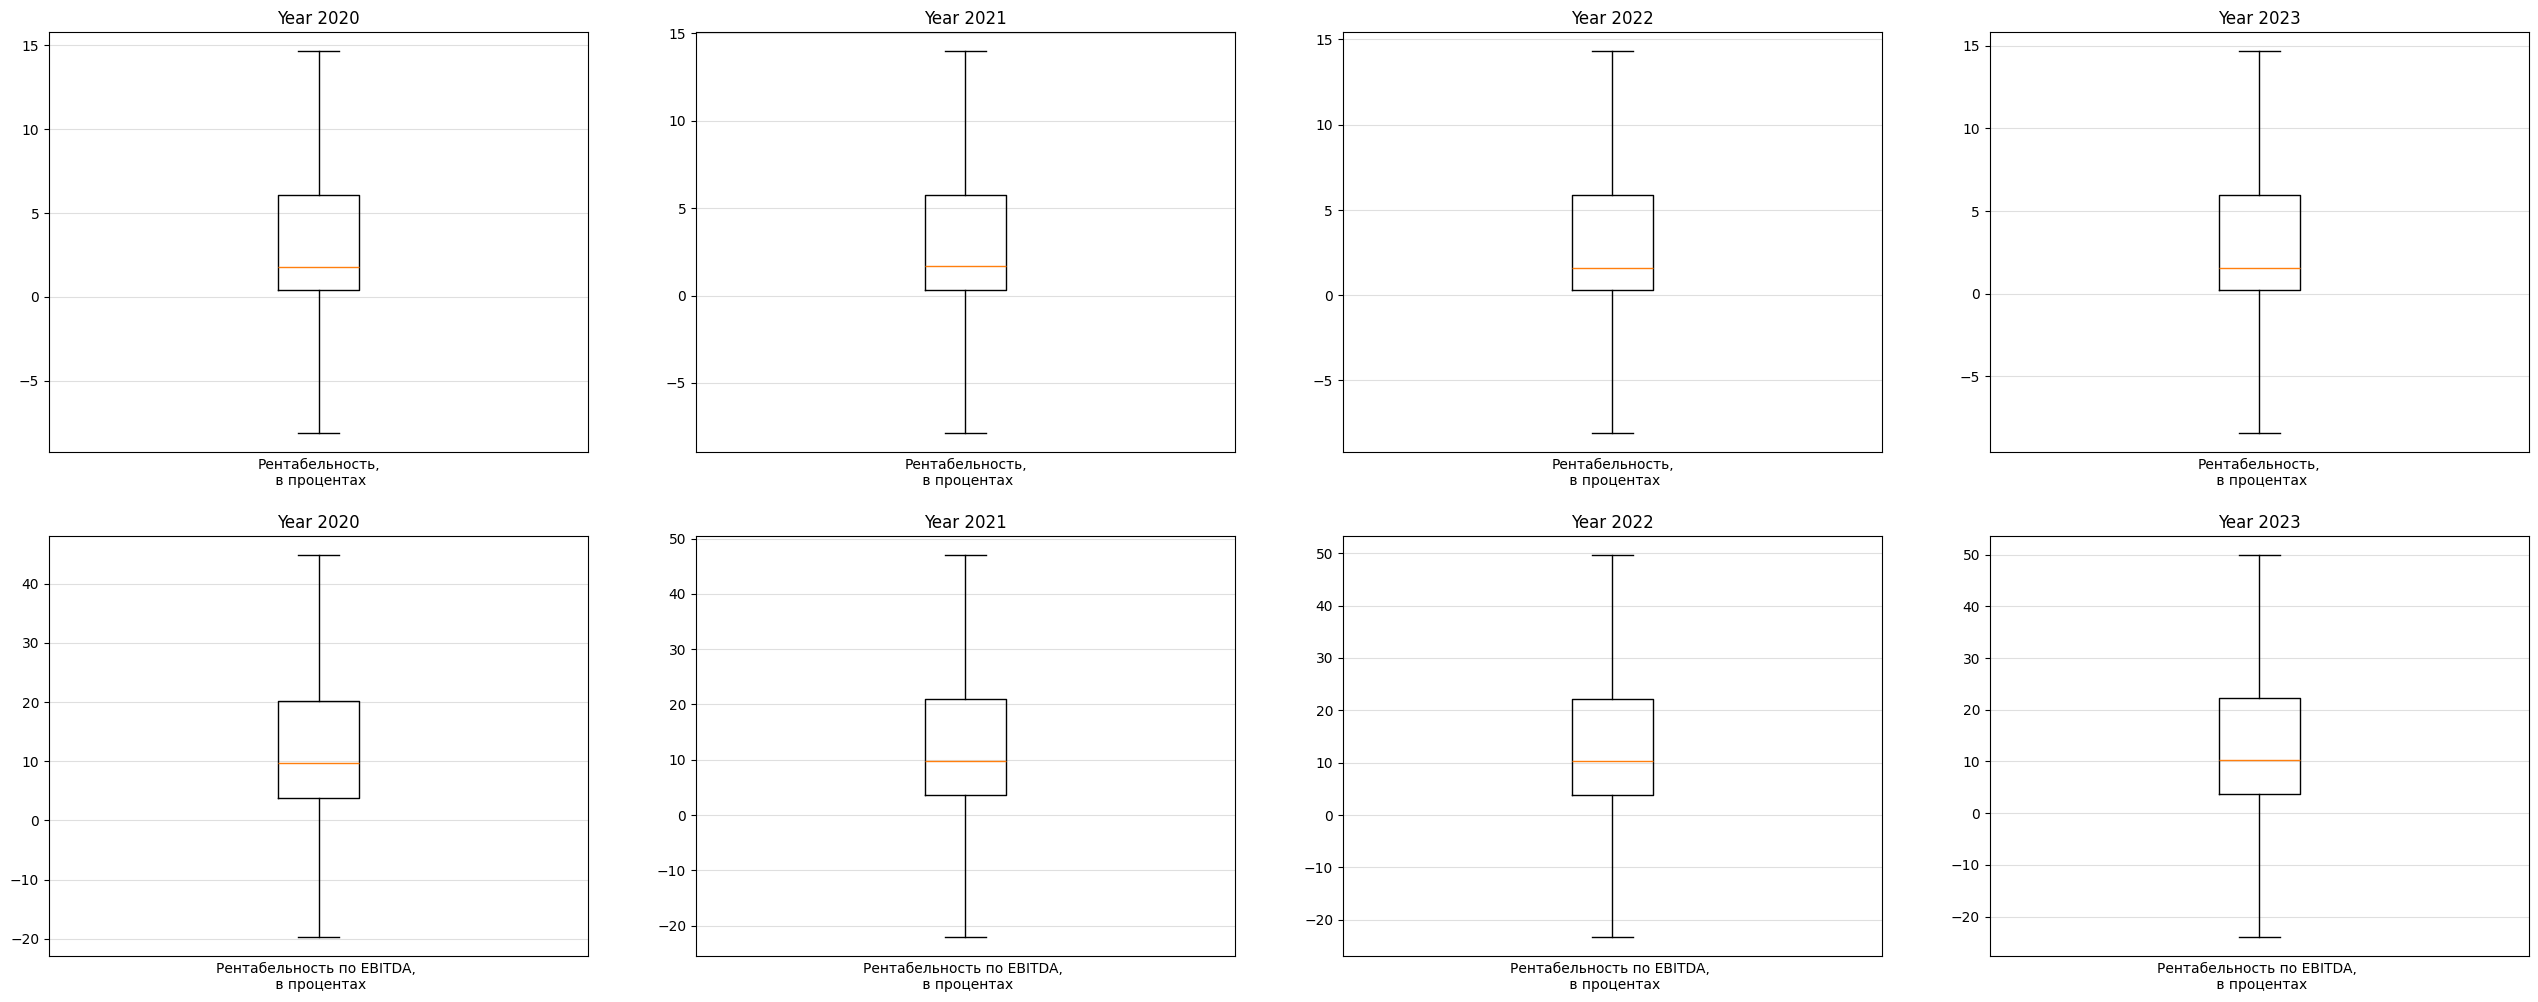

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(32, 12))

tmp_data = None

for i, ax in enumerate(axes.flat):
    if i < 4:
        tmp_data = profit_data[i]
    else:
        tmp_data = profit_ebitda_data[i-4]
    bin_width = 10
    bins = np.linspace(min(tmp_data), max(tmp_data), int(len(tmp_data) ** (2/3))) 
    ax.boxplot(x=tmp_data, showfliers=False)   
    ax.set_title(f"Year {i % 4 + 2020}")
    if i < 4:
        ax.set_xlabel("Рентабельность,\n в процентах")
    else:
        ax.set_xlabel("Рентабельность по EBITDA, \n в процентах")
    ax.grid(alpha=0.4)
    ax.set_xticks([])


# plt.grid()
plt.show()

- Видно, что рентабельность строительных фирм можно оценить, как низкую-среднюю

Чтобы лучше оценить прибыльность отрасли, посчитаем общий уровень прибыльности (будем брать чистую прибыль и выручку) и операционную 
прибыльность (берём EBITDA и выручку) сектора строительства 
с помощью метрики ROS (маржинальность, Рентабельность продаж) за разные годы:
$$ ROS = \frac{чистая \; прибыль \; всех \; компаний \; на \; рынке}{выручка \; всех \; компаний \; на \; рынке} * 100\%, \quad
 ROS\_EBITDA = \frac{EBITDA \; всех \; компаний \; на \; рынке}{выручка \; всех \; компаний \; на \; рынке} * 100\%$$

In [30]:
ros = np.array([
    100*((companies_data.loc[profit_data_ind[i]]['net_profit2400'].sum())/(companies_data.loc[profit_data_ind[i]]['revenue2110'].sum()))
    for i in range(4)
])

ros_ebitda = np.array([
    100*((companies_data.loc[profit_ebitda_data_ind[i]]['EBITDA'].sum())/(companies_data.loc[profit_ebitda_data_ind[i]]['revenue2110'].sum()))
    for i in range(4)
])

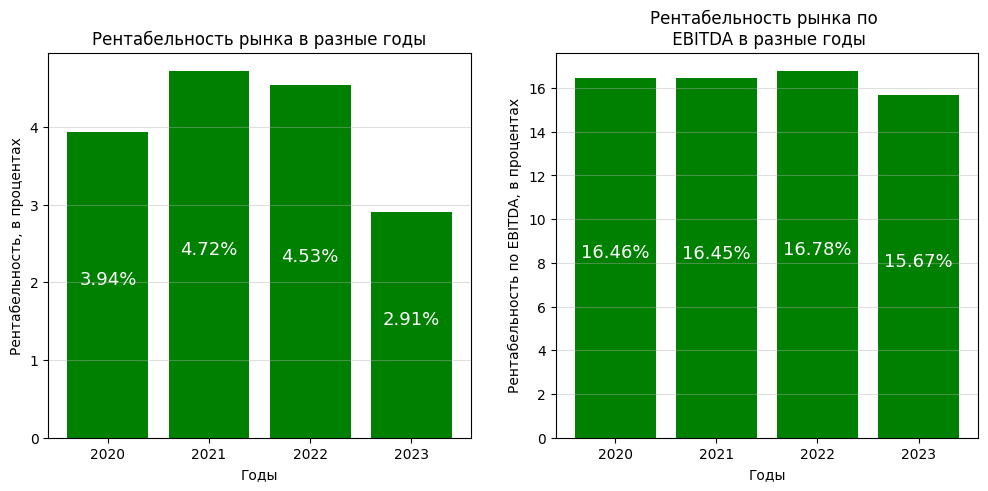

In [31]:
def addlabels1(ax, x,y):
    for i in range(len(x)):
        ax.text(i, y[i]/2, str(y[i].round(2))+"%", ha = 'center', color='white', size=13)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

years = [str(i) for i in range(2020, 2024)]

for i, ax in enumerate(axes):
    if i == 0:
        ax.bar(years, ros,color='green')
        ax.set_xlabel("Годы")
        ax.set_ylabel("Рентабельность, в процентах")
        ax.grid(axis='y',alpha=0.4)
        ax.set_title('Рентабельность рынка в разные годы')
        addlabels1(ax, years, ros)
    else:
        ax.bar(years, ros_ebitda,color='green')
        ax.set_xlabel("Годы")
        ax.set_ylabel("Рентабельность по EBITDA, в процентах")
        ax.grid(axis='y',alpha=0.4)
        ax.set_title('Рентабельность рынка по \n EBITDA в разные годы')
        addlabels1(ax, years, ros_ebitda)
plt.show()

Видно, что рентабельность отрасли и правда низкая. В 2023 году она ещё снизилась, как и рентабельность по EBITDA: рентабельность упала на ~1.6%, а рентабельность по EBITDA на ~1.1%

- Такая небольшая разница в падении может указывать на усиление неоперационных расходов на компаниях в 2023 году.

Давайте ещё посмотрим, как менялся суммарный показатель EBITDA за эти годы

In [32]:
ebitda_sum = np.array([companies_data[companies_data.period == i + 2020].dropna()['EBITDA'].sum() / 1000000 for i in range(4)])
ebitda_stat = pd.DataFrame({
    'year': [str(i) for i in range(2020, 2024)],
    'EBITDA': ebitda_sum.astype(float),
    'profit_EBITDA': ros_ebitda.astype(float)
})

print(ebitda_stat)

   year      EBITDA  profit_EBITDA
0  2020  195.832066      16.464738
1  2021  217.112774      16.448595
2  2022  252.304305      16.775487
3  2023  244.226462      15.674948


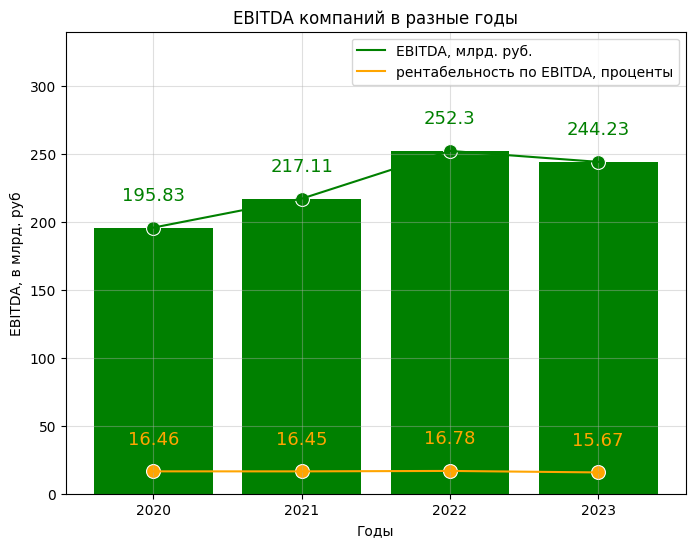

In [33]:
def addlabels(ax, x, y, h=1, color='black', size=10, ha='center'):
    for i in range(len(x)):
        ax.text(i, y[i]+h, y[i], ha = ha, color=color, size=size)

plt.figure(figsize=(8,6))

plt.bar(ebitda_stat['year'], ebitda_stat['EBITDA'], color='green')
plt.xlabel("Годы")
plt.ylabel("EBITDA, в млрд. руб")
plt.grid(alpha=0.4)
plt.title('EBITDA компаний в разные годы')

sns.lineplot(data=ebitda_stat, x="year", y="EBITDA", color="green",label='EBITDA, млрд. руб.')
sns.scatterplot(data=ebitda_stat, x='year', y='EBITDA', markers='o', s=100, color='green')

addlabels(plt, ebitda_stat['year'], ebitda_sum.round(2), 20, 'green', 13)

sns.lineplot(data=ebitda_stat, x="year", y="profit_EBITDA", color="orange", label='рентабельность по EBITDA, проценты')
sns.scatterplot(data=ebitda_stat, x='year', y='profit_EBITDA', markers='o', s=100, color='orange')

addlabels(plt, ebitda_stat['year'], ros_ebitda.round(2), 20, 'orange', 13)

plt.ylim(0, 340)

plt.legend()

plt.show()

- Отсюда видно, что с 2020 до 2022 EBITDA рос, а значит и рынок рос и развивался, а в 2023 и EBITDA, и рынок просели.

### Структура рынка

Интересно посмотреть на структуру самого рынка. Например, насколько более крупные компании зарабатывают больше, чем меньшие. Для этого посмотрим на разрыв между средним и медианным значениями EBITDA

In [34]:
ebitda_stat['ebitda_mean'] = [companies_data[companies_data.period == i + 2020].dropna()['EBITDA'].mean()/1000 for i in range(4)]
ebitda_stat['ebitda_median'] = [companies_data[companies_data.period == i + 2020].dropna()['EBITDA'].median()/1000 for i in range(4)]
ebitda_stat

,year,EBITDA,profit_EBITDA,ebitda_mean,ebitda_median
0,2020,195.832066,16.464738,56.878323,17.717
1,2021,217.112774,16.448595,58.082604,19.725
2,2022,252.304305,16.775487,63.313502,22.100
3,2023,244.226462,15.674948,59.063231,22.771


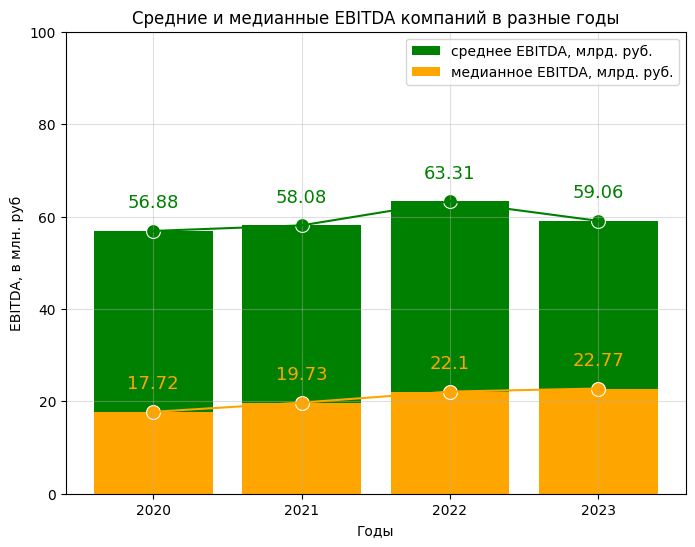

In [35]:
def addlabels2(ax, x, y, h=1, color='black', size=10, ha='center'):
    for i in range(len(x)):
        ax.text(i, y[i]+h, y[i], ha = ha, color=color, size=size)

plt.figure(figsize=(8,6))

plt.bar(ebitda_stat['year'], ebitda_stat['ebitda_mean'], label='среднее EBITDA, млрд. руб.', color='green')
plt.bar(ebitda_stat['year'], ebitda_stat['ebitda_median'], label='медианное EBITDA, млрд. руб.', color='orange')
plt.xlabel("Годы")
plt.ylabel("EBITDA, в млн. руб")
plt.grid(alpha=0.4)
plt.title('Средние и медианные EBITDA компаний в разные годы')

sns.lineplot(data=ebitda_stat, x="year", y="ebitda_mean", color="green")
sns.scatterplot(data=ebitda_stat, x='year', y='ebitda_mean', markers='o', s=100, color='green')

addlabels2(plt, years, ebitda_stat['ebitda_mean'].round(2), 5, 'green', 13)

sns.lineplot(data=ebitda_stat, x="year", y="ebitda_median", color="orange")
sns.scatterplot(data=ebitda_stat, x='year', y='ebitda_median', markers='o', s=100, color='orange')

addlabels2(plt, years, ebitda_stat['ebitda_median'].round(2), 5, 'orange', 13)

plt.ylim(0, 100)

plt.legend()

plt.show()

- Видно, что разрыв высокий. Значит лишь у маленького числа фирм доходы очень высокие, по сравнению с большинством фирм.

### Рост (падение) чистой прибыли в 2023 относительно 2020 года

Проанализируем рост (падение) чистой прибыли относительно 2020 года

Но перед этим напомним, что для 2020 и 2023 годов доступно 10008 и 10914 компаний соответственно

In [36]:
companies_data.period.value_counts()

period
2023    10914
2022    10566
2021    10241
2020    10008
2024      149
Name: count, dtype: int64

Из них прибыли доступно для 9913 и 10811 компаний соответственно

In [37]:
aval_profit_20 = companies_data[companies_data.period == 2020].net_profit2400.dropna().shape[0]
aval_profit_23 = companies_data[companies_data.period == 2023].net_profit2400.dropna().shape[0]
print(f"{aval_profit_20}, {aval_profit_23}")

9913, 10811


При этом только для 9727 компаний доступна прибыль, как за 2020, так и за 2023

In [38]:
id_profit_20 = set(companies_data.loc[companies_data[companies_data.period == 2020].net_profit2400.dropna().index]['id'])
id_profit_23 = set(companies_data.loc[companies_data[companies_data.period == 2023].net_profit2400.dropna().index]['id'])
print(len(id_profit_20.intersection(id_profit_23)))

9727


In [39]:
net_profit_period20 = companies_data[companies_data.period == 2020].rename(columns={'net_profit2400': 'profit2020'})
net_profit_period23 = companies_data[companies_data.period == 2023].rename(columns={'net_profit2400': 'profit2023'})

data_growth = pd.merge(net_profit_period20, net_profit_period23, on='id')

data_growth = data_growth[['id', 'inn_x', 'fullName_x', 'address_x', 'profit2020', 'profit2023']].rename(columns={
    'inn_x':'inn', 'fullName_x':'fullName', 'address_x':'address'
})

In [40]:
data_growth = data_growth.assign(
                    growth=np.where(
                        abs(data_growth.profit2020) < EPS,
                        None,
                        ((data_growth.profit2023 - data_growth.profit2020)/abs(data_growth.profit2020))*100
                    )                
                 )
data_growth = data_growth.loc[data_growth['profit2020'].dropna().index]
data_growth = data_growth.loc[data_growth['profit2023'].dropna().index]

In [41]:
print(f"Только для {data_growth.shape[0]} компаний доступна прибыль, как за 2020, так и за 2023")

Только для 9727 компаний доступна прибыль, как за 2020, так и за 2023


In [42]:
data_growth = data_growth.loc[data_growth['growth'].dropna().index]

Теперь построим графики по количеству компаний с похожими процентами роста(падения) за этот период. Правда в данных роста/падения есть выбросы, поэтому для красоты 1 графика избавимся от них.

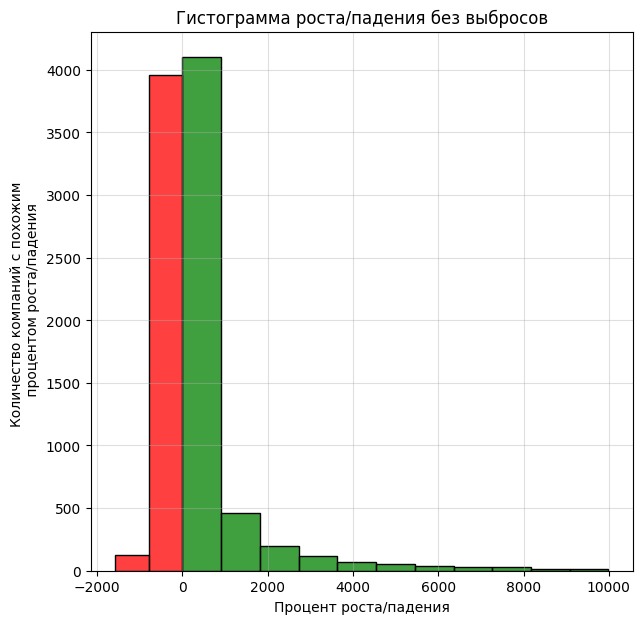

In [43]:
plt.figure(figsize=(7, 7))

q_low, q_high = np.percentile(data_growth['growth'], [2.5, 97.5])
filtered_data = data_growth[(data_growth['growth'] >= q_low) & (data_growth['growth'] <= q_high)]

bins_count = int((3/2)*math.log(len(filtered_data)))
bin_step = (q_high-q_low)/bins_count

filtered_data_plus = filtered_data[filtered_data['growth'] >= 0]
filtered_data_minus = filtered_data[filtered_data['growth'] <= 0]

sns.histplot(filtered_data_plus, x='growth', binwidth=bin_step, color='green')
sns.histplot(filtered_data_minus, x='growth', binwidth=bin_step, color='red')

plt.xlabel('Процент роста/падения')
plt.ylabel('Количество компаний с похожим \n процентом роста/падения')
plt.title('Гистограмма роста/падения без выбросов')

plt.grid(alpha=0.4)

plt.show()

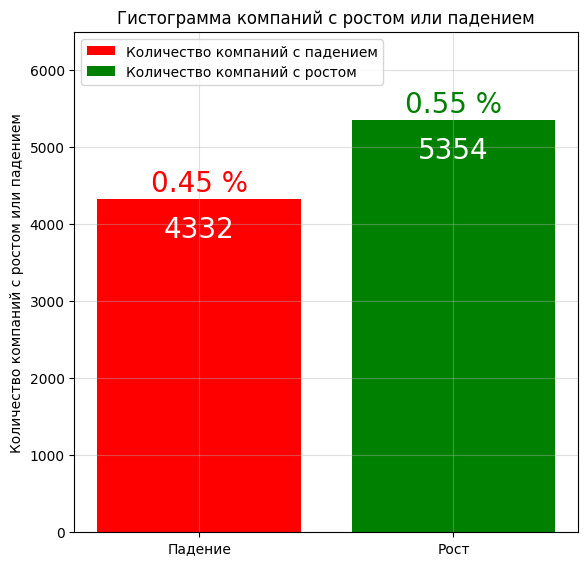

In [44]:
def addlabels3(ax, x, heights, names, colors, size=10, ha='center'):
    for i in range(len(x)):
        ax.text(i, heights[i], names[i], color=colors[i], size=size,  ha = ha)

plt.figure(figsize=(6.5, 6.5))

data_growth_plus = data_growth[data_growth['growth'] >= 0].shape[0]
data_growth_minus = data_growth[data_growth['growth'] <= 0].shape[0]

x = np.array(['Падение', 'Рост'])
heights = np.array([data_growth_minus, data_growth_plus])
colors = np.array(['red', 'green'])
names = np.array([str(np.round(elem/data_growth.shape[0], 2))+" %" for elem in heights])
titles = ['Количество компаний с падением', 'Количество компаний с ростом']

plt.bar(x=x, height=heights, color=colors, label=titles)
# plt.xlabel('')
plt.ylabel('Количество компаний с ростом или падением')
plt.title('Гистограмма компаний с ростом или падением')

# sns.scatterplot(data=ebitda_stat, x='year', y='ebitda_median', markers='o', s=100, color='orange')

addlabels3(plt, x, heights+100, names, colors, 20)
addlabels3(plt, x, heights-500, heights, ['w', 'w'], 20)

plt.ylim((0, 6500))
plt.legend(loc='upper left')
plt.grid(alpha=0.4)
plt.show()

- Видно, что прибыль выросла у большего числа компаний за 4 года

### Географическое расположение топовых компаний

Нанесём на карту место регистрации компаний с максимальной выручкой за 2023 год.

Для нанесения компаний на карту, нам потребуются координаты адресов регистрации компаний (lat/lng). А у нас есть только адреса компаний.
Для нахождения координат воспользуемся API Yandex Maps.

In [45]:
top_companies = companies_data.sort_values(by=['revenue2110'], ascending=False)[:501]
top_companies.head(3)

,id,inn,fullName,address,period,revenue2110,cost_sales2120,interest_payable2330,net_profit2400,income_tax2410,EBITDA,profit_EBITDA,profit
15649,7831808,8.601049e+09,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""МОНТ...","643,628012,86,,Ханты-Мансийск г,,Чехова ул,70,,",2021,77138000.0,-73393323.0,NaN,1622677.0,1793000.0,NaN,NaN,2.103603
14275,9005710,7.728901e+09,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""СПЕЦ...","107497, Москва г, ул Амурская, 7, 3",2022,12256928.0,4097787.0,40154.0,-2151733.0,-140526.0,8058769.0,65.748685,-17.555239
17245,7436034,7.731434e+09,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ОРГН...","123290, Москва г, туп Магистральный 1-й, 5А, 35",2020,11543639.0,-10585590.0,-5835.0,295209.0,-102636.0,22020758.0,190.760972,2.55733


**Следующая ячейка для скачивания данных. Не запускайте её, если данные уже есть в папке data**

In [1]:
import xml.etree.ElementTree as ET
def is_number(string):
    try:
        float(string)
        return True 
    except ValueError:
        return False

def extract_address_components(address):
    tmp = address.split(',')
    flag_start = True
    results = []
    for elem in tmp:
        if elem != '':
            if not is_number(elem):
                flag_start = False
                results.append(elem)
            elif not flag_start:
                results.append(elem)
    if len(results) >= 3:
        results = results[:3]
        match = re.search(r'(?:д\.|№)\s*(\d+)', results[2])
        results[2] = match.group(1) if match else results[2]
    return "+".join(results)

    

with open("data/location_companies.csv", 'w', encoding='utf-8') as output:
    output.write("id,inn,address,lng,lat\n")
    for elem in tqdm(zip(top_companies['id'].to_list(),top_companies['inn'].to_list(),top_companies['address'].to_list())):
        norm_address = extract_address_components(elem[2])
        params = {"apikey": '****', "geocode": norm_address, "lang": "ru_RU", "fotmat":"json"}
        res = requests.get("https://geocode-maps.yandex.ru/1.x", params=params)
        # 
        root = ET.fromstring(res.text)
        namespaces = {'gml': 'http://www.opengis.net/gml'}
        pos = root.find('.//gml:Point/gml:pos', namespaces)
        lng, lat = None, None
        if pos is not None:
            lng, lat = pos.text.split()
        # 
        output.write(f"{elem[0]},{elem[1]},{norm_address},{lng},{lat}\n")

УРА! Мы скачали координаты компаний. Теперь с помощью geopandas отметим их место регистрации на карте

In [57]:
import pandas as pd
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

companies_location = pd.read_csv("data/location_companies.csv")

fig = px.scatter_map(companies_location, lat="lat", lon="lng", color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(map_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show(renderer="notebook_connected")

- Как видно, большинство компаний сосредоточенно в Центральном регионе России: в основном в Москве и Московской области. Хотя есть и скопление в Санкт-Петербурге и других крупных городах России

## Вывод

Итак, мы проанализировали рынок строительной отрасли. Из полученных результатов можно сделать следующие выводы:
- Рынок демонстрировал рост с 2020 по 2022 год, но в 2023 году начался небольшой спад, вероятно, из-за повышенных расходов (правда результатов за 2024 год у нас на момент создания отчёта у нас нет). При всём этом 55% компаний показали рост чистой прибыли за 4 года, что может говорить об улучшающейся ситуации в отрасли с 2020 по 2023 год.
- С общей точки зрения рентабельность отрасли в целом средняя.
- В отрасли есть небольшая группа высокодоходных компаний.
- Основные игроки сконцентрированы в крупнейших городах России.
Таким образом, несмотря на общий рост отрасли, структура рынка остается неравномерной, а недавний спад в 2023 году может сигнализировать о возможных рисках. Вложение в отрасль требует осторожности, особенно с учетом высокой концентрации доходов у ограниченного числа компаний.